# Data sampling and Image size reshaping

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, classification_report
import pandas as pd
from keras.callbacks import Callback
from IPython.display import clear_output

## Reading statistics

In [2]:
# stats_file = "image_dimensions.csv"
stats_file = "/kaggle/input/image-dimensions/image_dimensions.csv"
stats = pd.read_csv(stats_file)
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2797.000000,2797.000000
mean,603.319271,648.314623
std,415.975788,446.883172
min,106.000000,108.000000
25%,314.000000,383.000000
50%,550.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,550.000000,590.000000


## Helper functions

In [3]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [4]:
def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model(median_width, median_height)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 550, 590, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 548, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 274, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 272, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 136, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 134, 144, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 67, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 65, 70, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 33, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 253440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         253,441 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

In [6]:
def print_metrics(model, test):
    y_pred_prob = model.predict(test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test], axis=0)

    auc_score = roc_auc_score(y_true, y_pred_prob)

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        ax=ax[0]
    )
    ax[0].set_title('Confusion Matrix')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc='lower right')
    ax[1].grid()

In [7]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Basic data augmentation

In [19]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3,0.3)
])

In [20]:
painters = ["Rubens", "Picasso"]
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
# dataset_dir = "undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


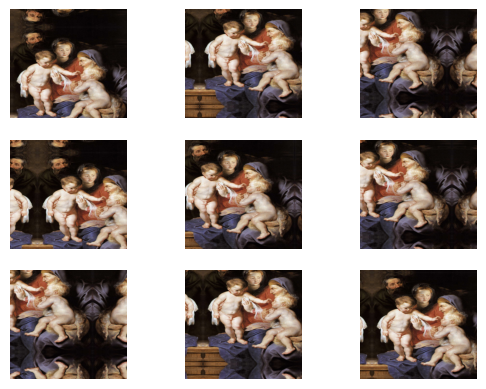

In [21]:
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Undersampled dataset

### Rubens en picasso

In [22]:
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
# dataset_dir = "undersampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


#### Model trainen zonder data augmentation

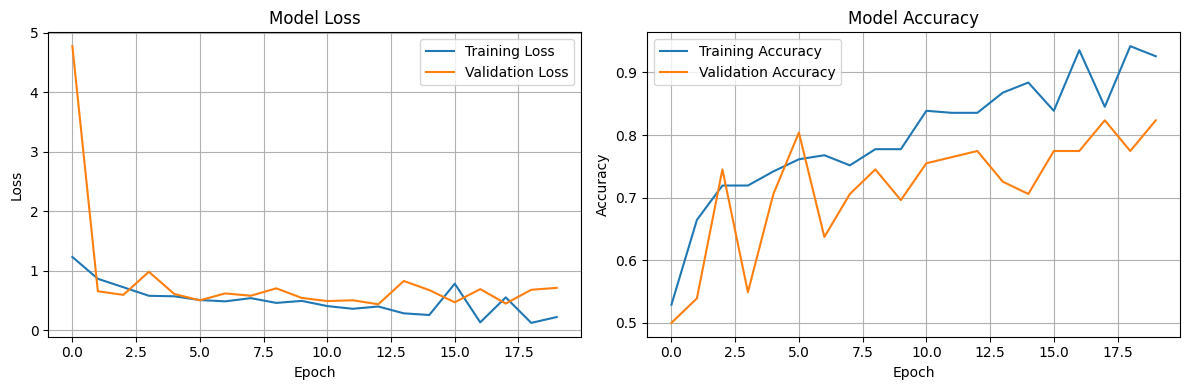

In [11]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Accuracy:  0.5294117647058824
Recall:  0.37254901960784315
Precision:  0.5428571428571428
F1:  0.4418604651162791


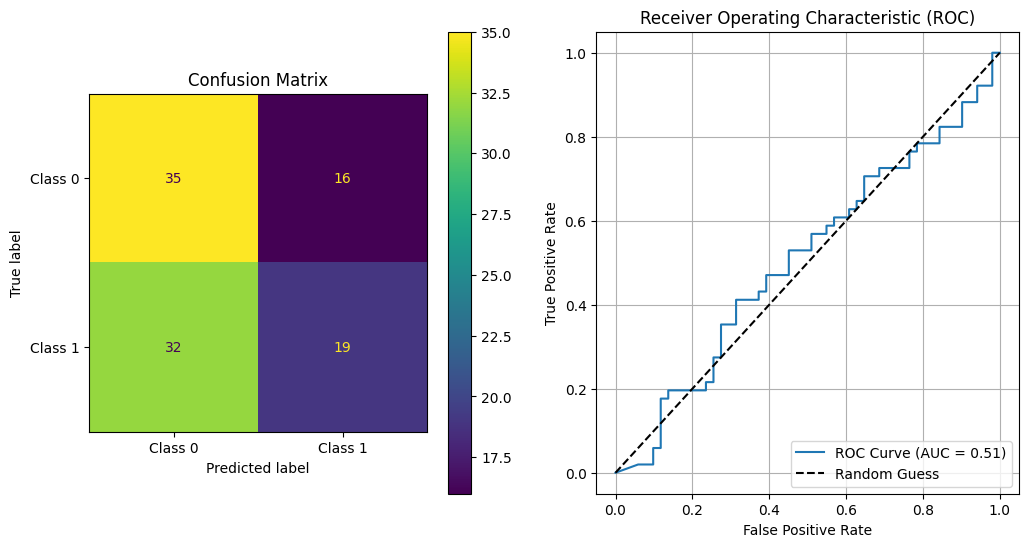

In [12]:
print_metrics(model, test)

#### Model trainen met data augmentation

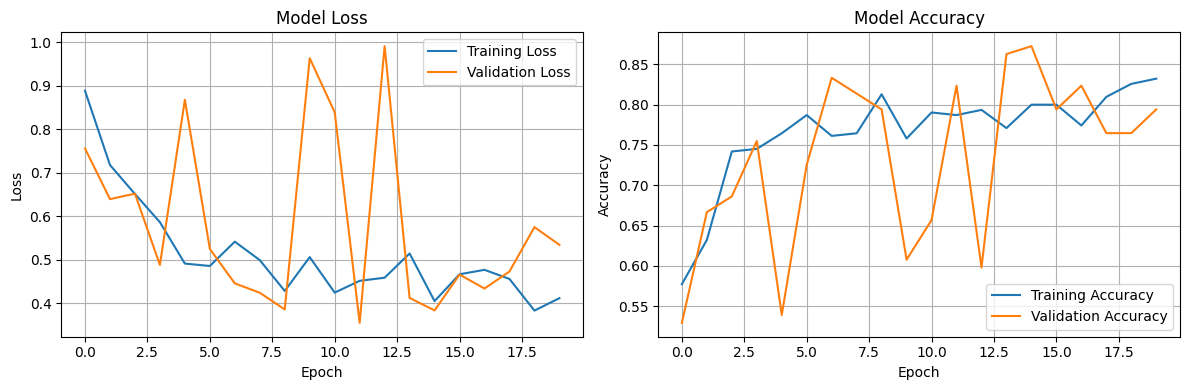

In [23]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Accuracy:  0.5392156862745098
Recall:  0.6862745098039216
Precision:  0.5303030303030303
F1:  0.5982905982905983


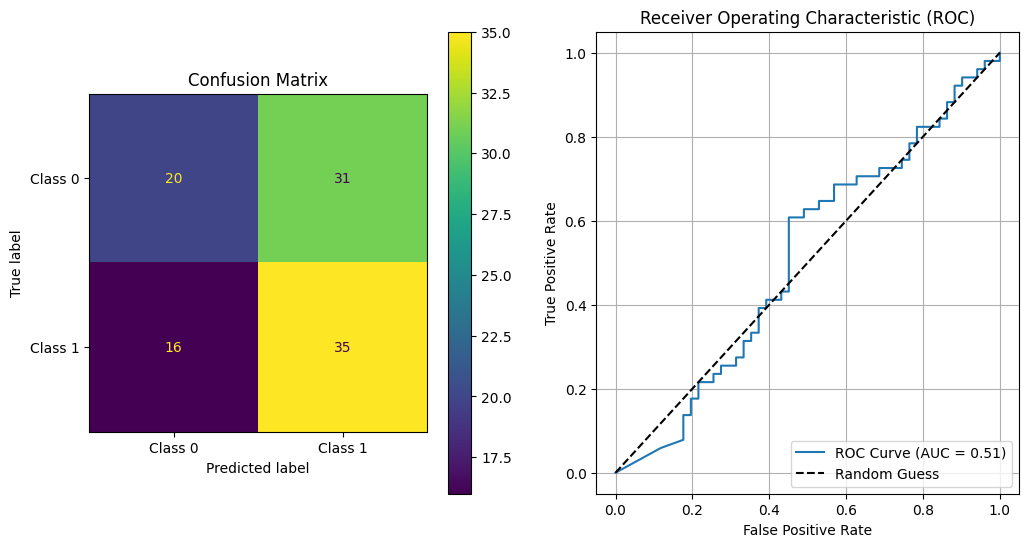

In [24]:
print_metrics(model, test)

### Mondriaan en Rubens

In [25]:
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
# dataset_dir = "undersampled_dataset"
painters = ["Mondriaan", "Rubens"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


#### Model trainen zonder data augmentation

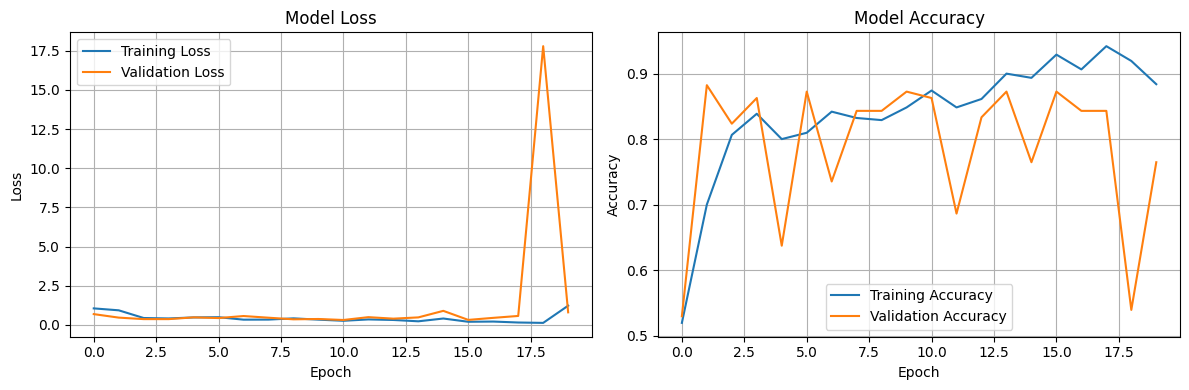

In [15]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Accuracy:  0.5098039215686274
Recall:  0.5490196078431373
Precision:  0.509090909090909
F1:  0.5283018867924528


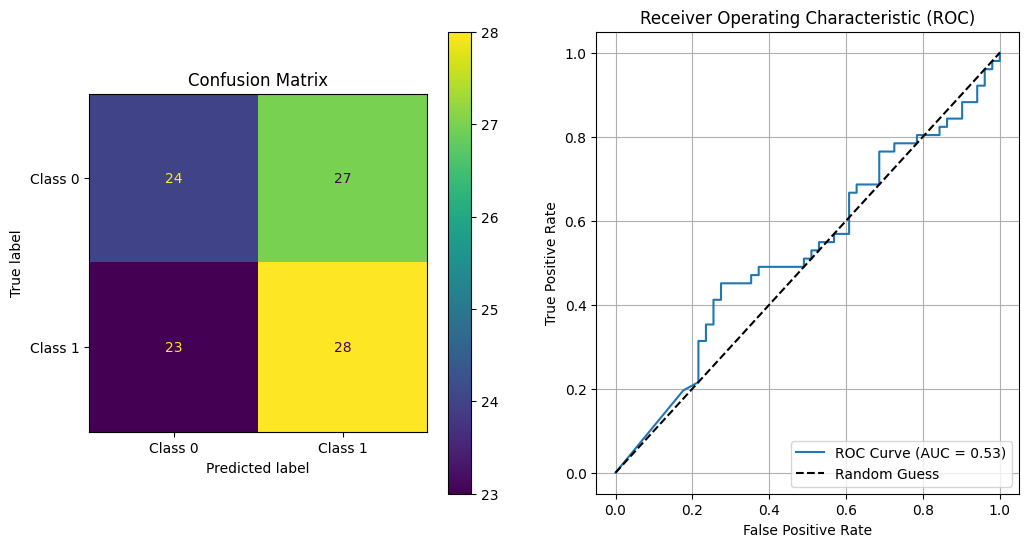

In [16]:
print_metrics(model, test)

#### Model trainen met data augmentation

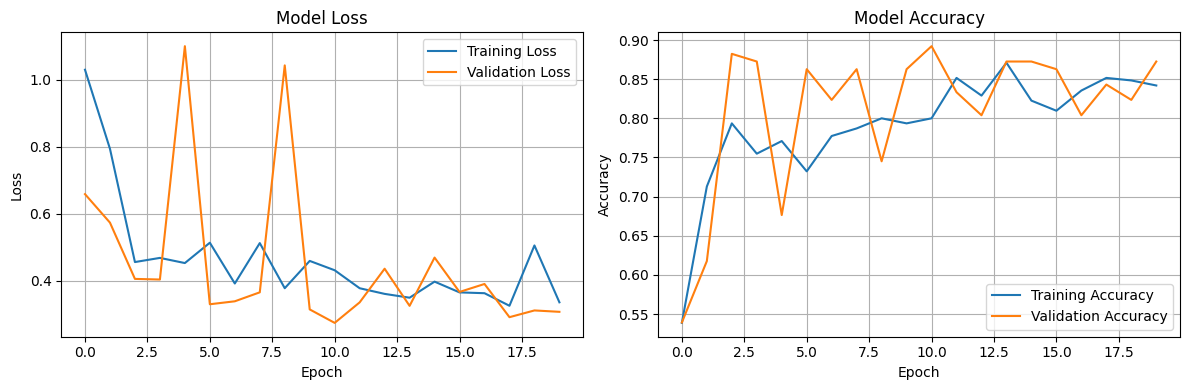

In [26]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy:  0.5490196078431373
Recall:  0.49019607843137253
Precision:  0.5555555555555556
F1:  0.5208333333333333


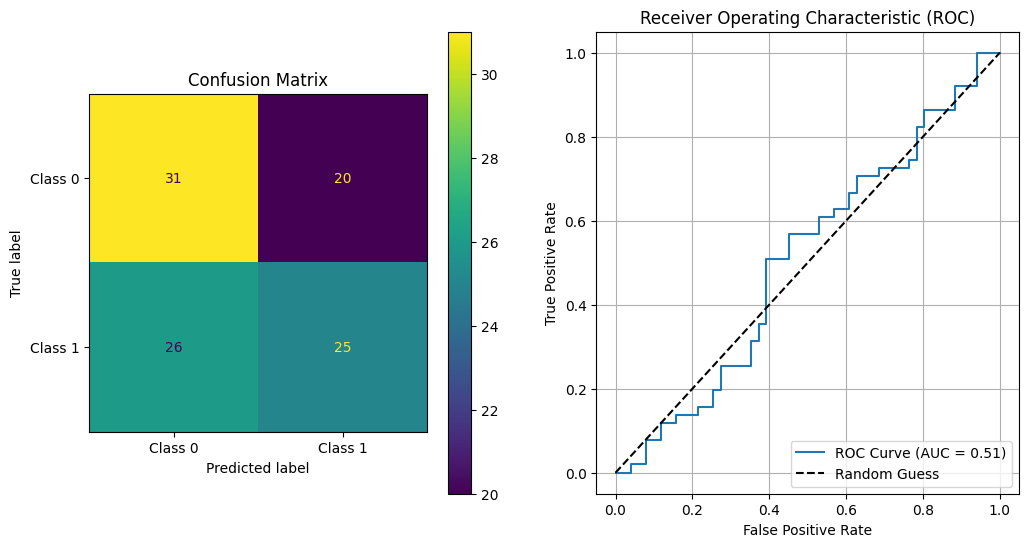

In [27]:
print_metrics(model, test)

## Oversampled dataset

### Rubens en picasso

In [28]:
# dataset_dir = "oversampled_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.


#### Model trainen zonder data augmentation

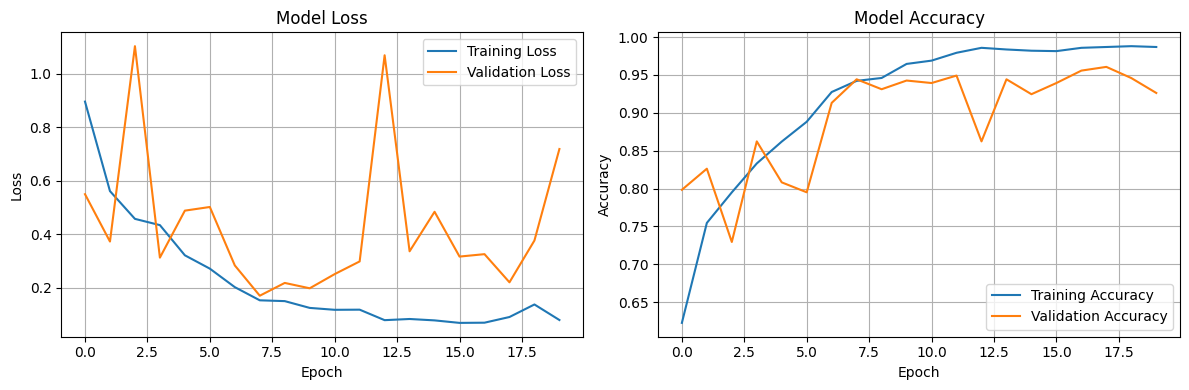

In [29]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Accuracy:  0.48688524590163934
Recall:  0.4491803278688525
Precision:  0.4858156028368794
F1:  0.4667802385008518


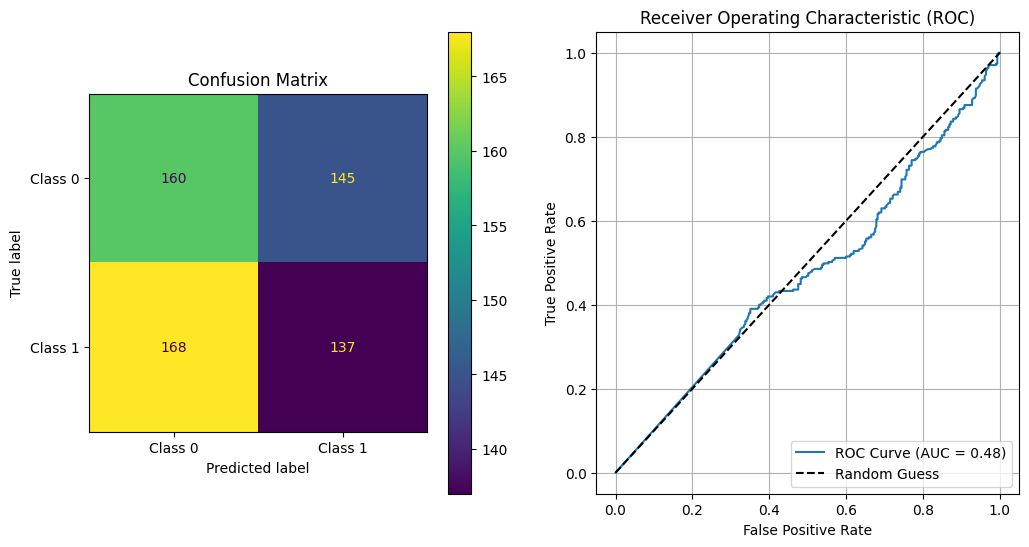

In [30]:
print_metrics(model, test)

#### Model trainen met data augmentation

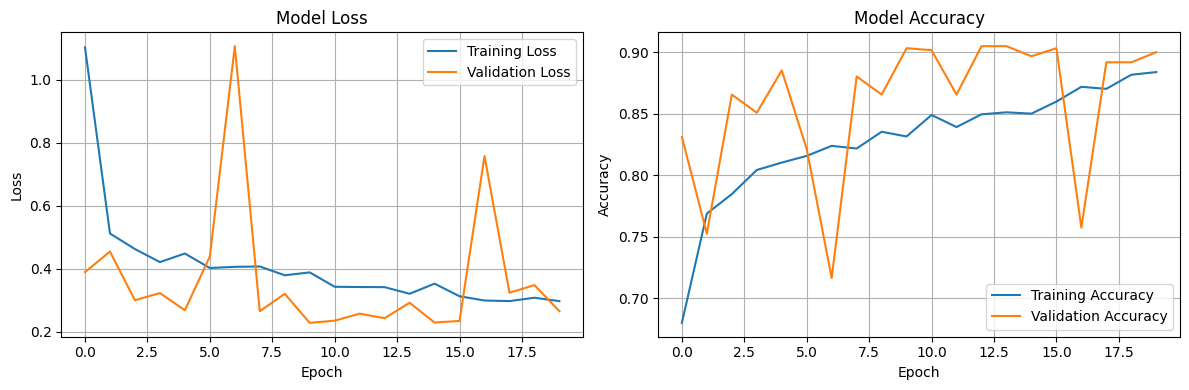

In [31]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Accuracy:  0.4852459016393443
Recall:  0.3901639344262295
Precision:  0.4817813765182186
F1:  0.431159420289855


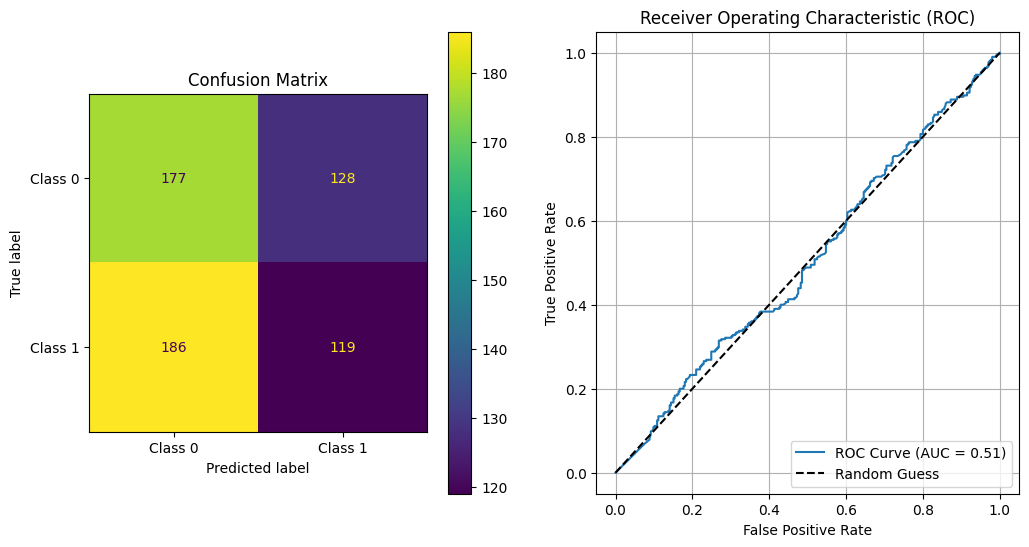

In [32]:
print_metrics(model, test)

### Mondriaan en Rembrandt

#### Model trainen zonder data augmentation

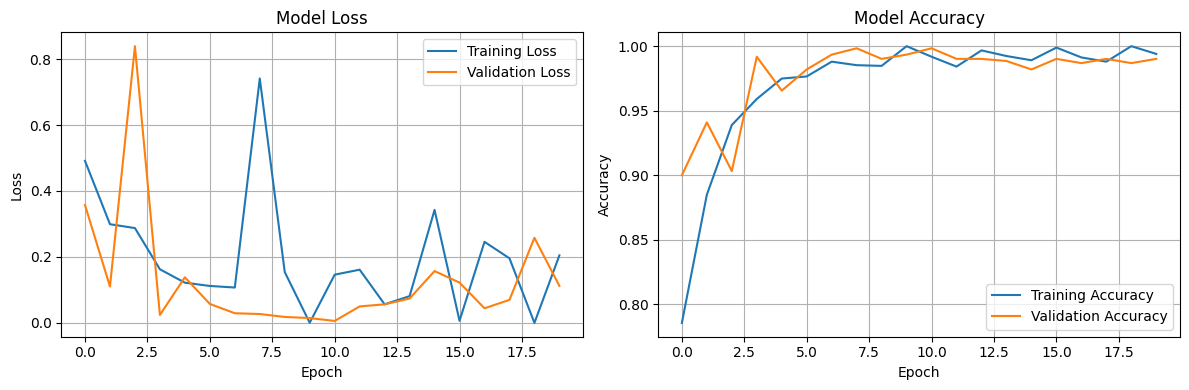

In [33]:
# dataset_dir = "oversampled_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
painters = ["Mondriaan", "Rembrandt"]
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Accuracy:  0.5262295081967213
Recall:  0.5278688524590164
Precision:  0.5261437908496732
F1:  0.5270049099836335


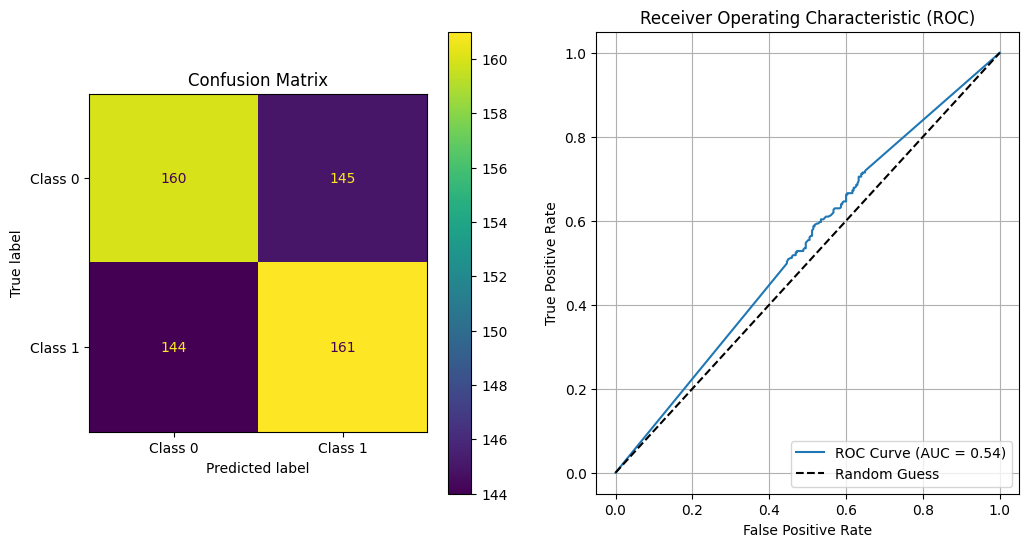

In [34]:
print_metrics(model, test)

#### Model trainen met data augmentation

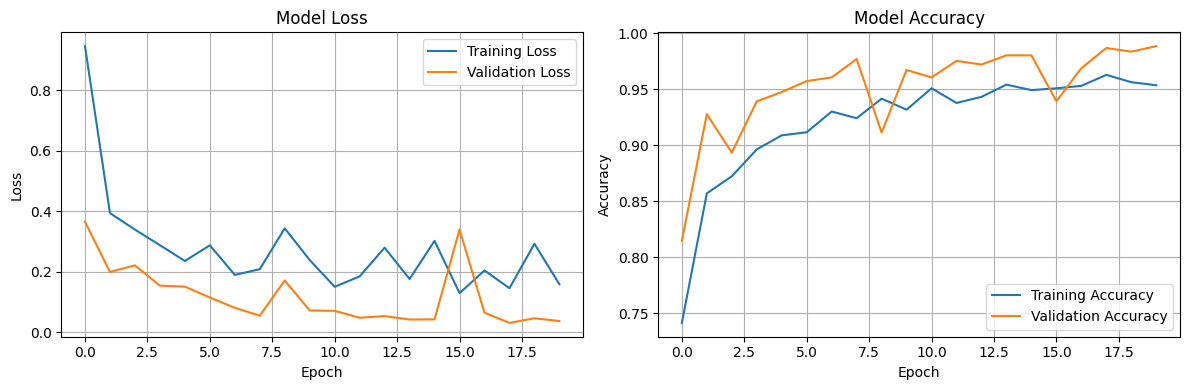

In [37]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, verbose=0)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Accuracy:  0.4672131147540984
Recall:  0.46885245901639344
Precision:  0.4673202614379085
F1:  0.46808510638297873


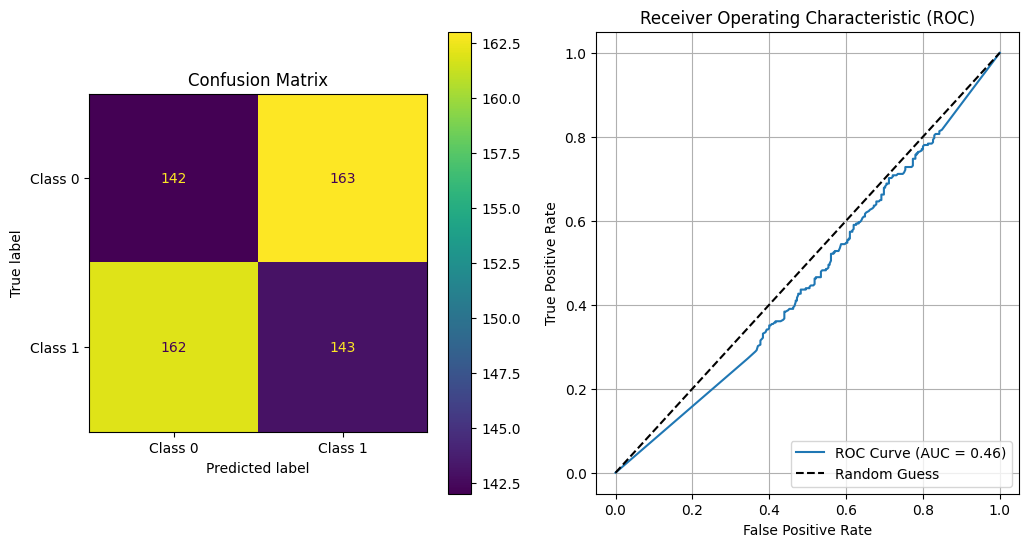

In [38]:
print_metrics(model, test)

## Imbalanced dataset

In [39]:
# dataset_dir = "imbalanced_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
painters = ["Rubens", "Picasso"]
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 1323 files belonging to 2 classes.
Found 444 files belonging to 2 classes.
Found 440 files belonging to 2 classes.


### Rubens en picasso

#### Class weights bepalen

In [40]:
train.class_names

['Rubens', 'Picasso']

In [41]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1323, {1: 917, 0: 406})

In [42]:
rubens_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / rubens_count) * (total / 2.0)) if rubens_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 1.6293103448275863, 1: 0.7213740458015268}

#### Baseline

In [43]:
picasso_count / total

0.6931216931216931

#### Model trainen zonder data augmentation

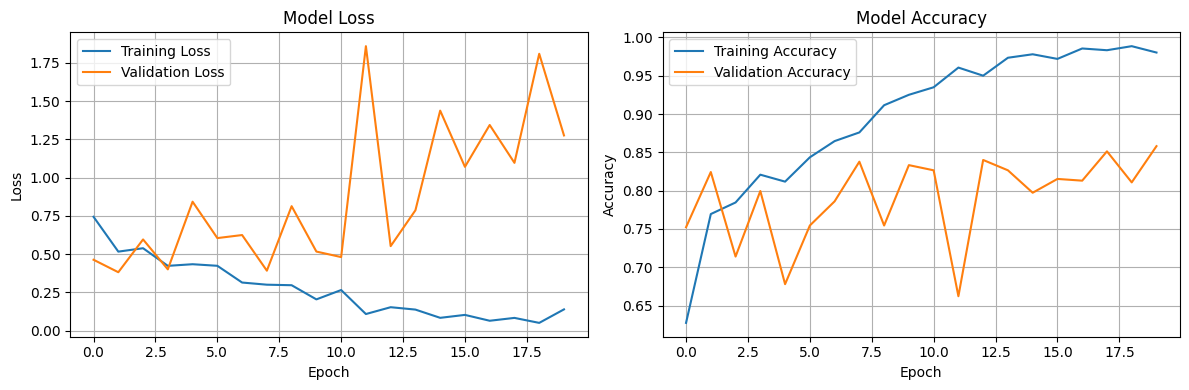

In [45]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step
Accuracy:  0.5659090909090909
Recall:  0.6950819672131148
Precision:  0.6838709677419355
F1:  0.689430894308943


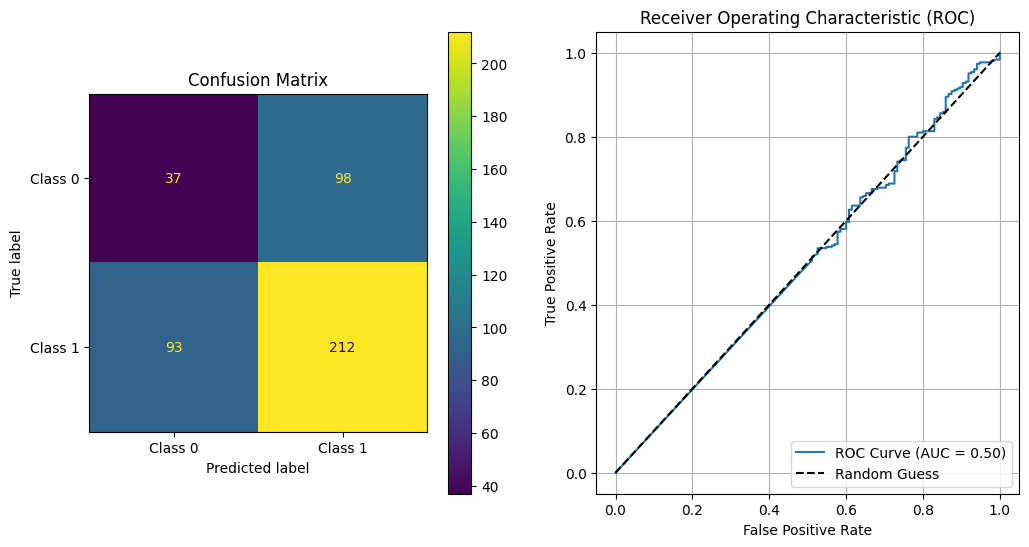

In [46]:
print_metrics(model, test)

#### Model trainen met data augmentation

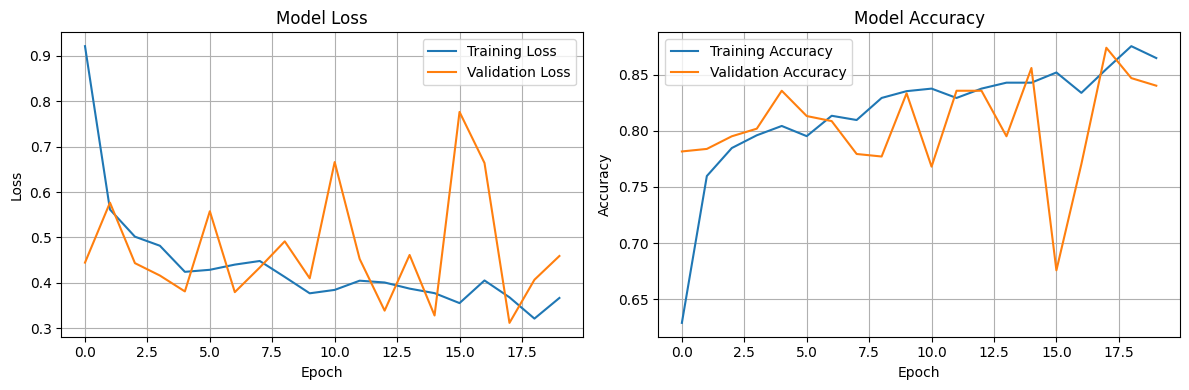

In [48]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Accuracy:  0.625
Recall:  0.8032786885245902
Precision:  0.7
F1:  0.7480916030534351


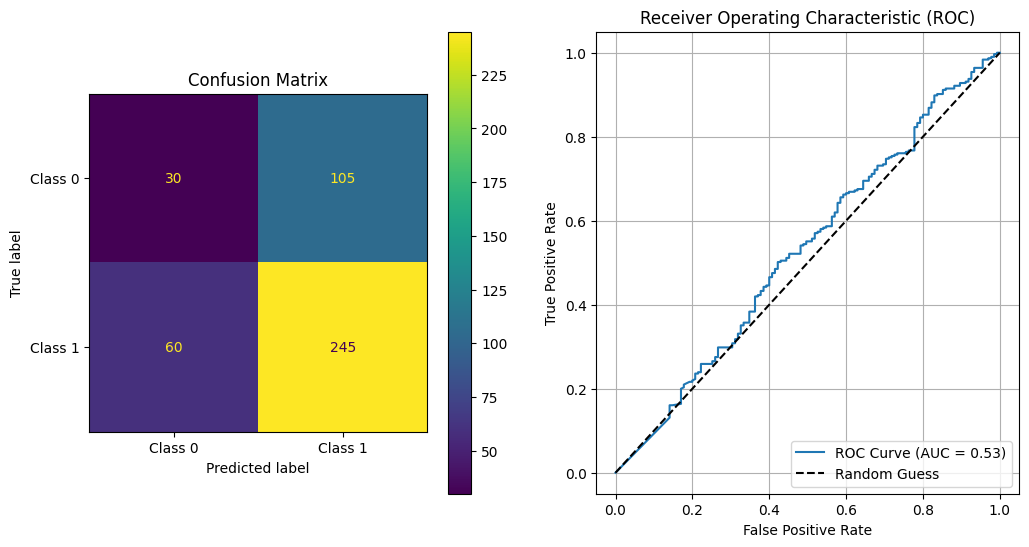

In [49]:
print_metrics(model, test)

### Mondriaan en Rembrandt

#### Data inladen

In [50]:
painters = ["Mondriaan", "Rembrandt"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height, batch_size=16)

Found 354 files belonging to 2 classes.
Found 118 files belonging to 2 classes.
Found 118 files belonging to 2 classes.


#### Class weights bepalen

In [51]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(354, {0: 198, 1: 156})

In [52]:
mondriaan_count = class_counts.get(0, 0)  
rembrandt_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / rembrandt_count) * (total / 2.0)) if rembrandt_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 0.893939393939394, 1: 1.1346153846153846}

#### Baseline

In [53]:
mondriaan_count / total

0.559322033898305

#### Model trainen zonder data augmentatie

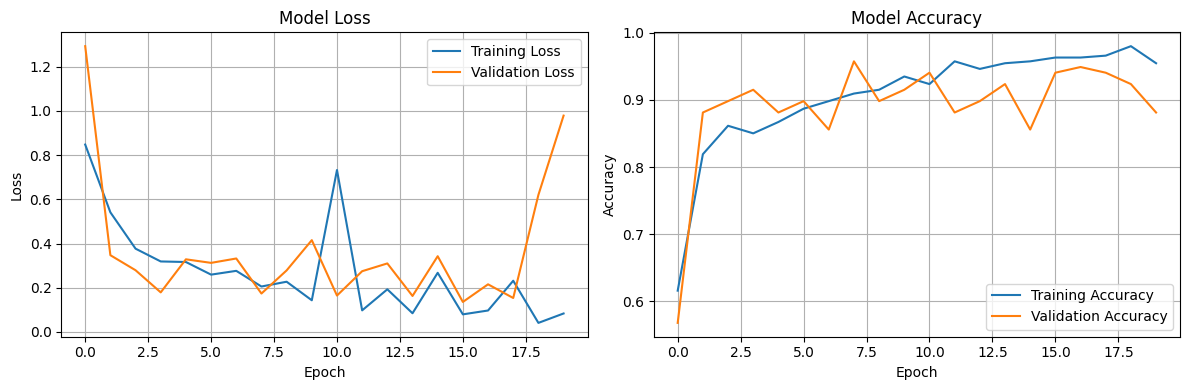

In [54]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Accuracy:  0.4830508474576271
Recall:  0.3269230769230769
Precision:  0.3953488372093023
F1:  0.3578947368421052


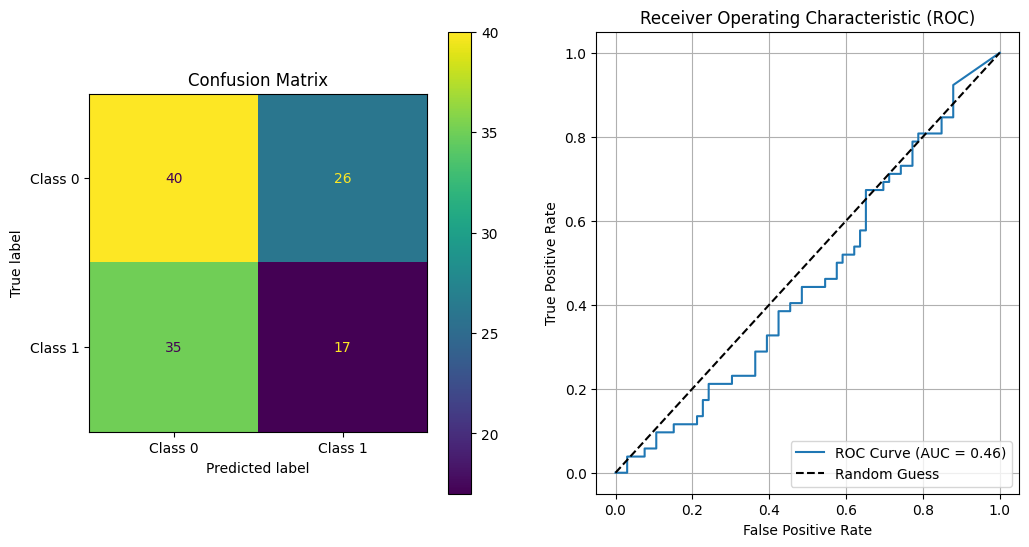

In [55]:
print_metrics(model, test)

#### Model trainen met data augmentatie

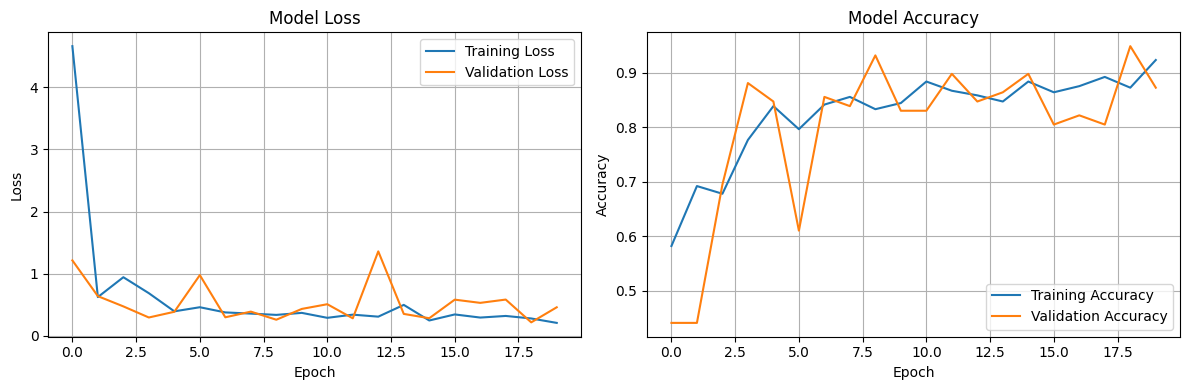

In [56]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced_data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(median_width, median_height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Accuracy:  0.4915254237288136
Recall:  0.3076923076923077
Precision:  0.4
F1:  0.34782608695652173


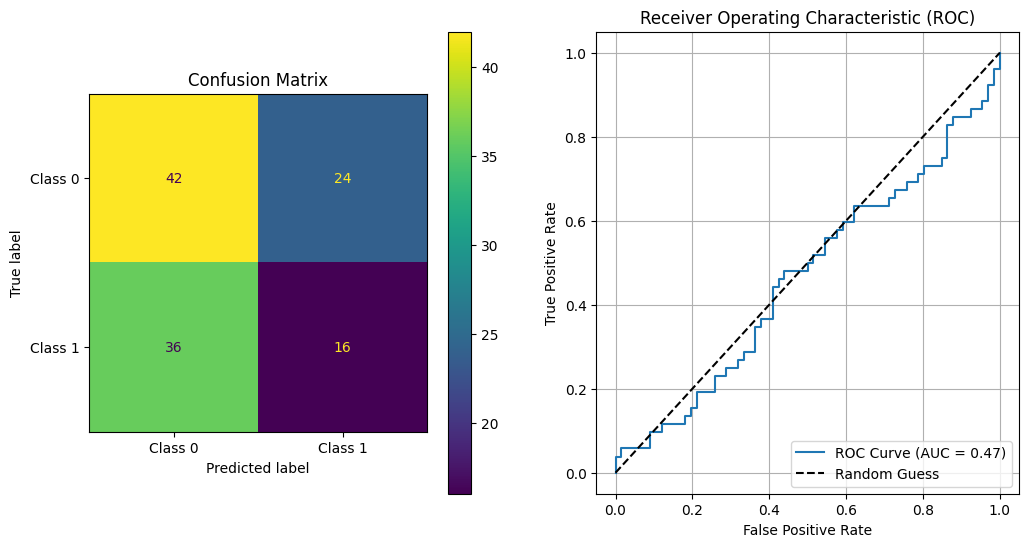

In [57]:
print_metrics(model, test)

## Image size bepalen

In [51]:
statistics = ["min", "25%", "median", "mean", "75%"]
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
painters = ["Mondriaan", "Picasso"]

results = []

for statistic in statistics:
    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    for interpolation in interpolations:
        print(statistic, interpolation)
        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)
        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath="gridsearch_model.keras", save_best_only=True, monitor="val_loss")]
        history = model.fit(train, epochs=15, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

        y_pred_prob = model.predict(test)
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)
        y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        test_accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred_prob)
        
        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc": auc_score
        })
        print(results[-1])

df = pd.DataFrame(results)

min bilinear
Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 108, 'train_accuracy': 0.9739910364151001, 'val_accuracy': 0.9329758882522583, 'test_accuracy': 0.7088948787061995, 'train_loss': 0.0850418284535408, 'val_loss': 0.23261259496212006, 'precision': 0.8250825082508251, 'recall': 0.819672131147541, 'f1_score': 0.8223684210526316, 'auc': 0.5298310978638847}
min nearest
Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 108, 'train_accuracy': 0.9856502413749695, 'val_accuracy': 0.9008042812347412, 'test_accuracy': 0.6954177897574124, 'train_loss': 0.05074608698487282, 'val_loss': 0.48193106055259705, 'precision': 0.815

In [52]:
df.sort_values("test_accuracy", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
17,median,area,550,590,0.964126,0.895442,0.797844,0.134882,1.276011,0.832370,0.944262,0.884793,0.534799
16,median,bicubic,550,590,0.966816,0.908847,0.776280,0.132820,0.531361,0.832335,0.911475,0.870110,0.487556
29,75%,nearest,800,826,0.981166,0.924933,0.727763,0.079351,0.589723,0.818750,0.859016,0.838400,0.519598
15,median,nearest,550,590,0.965919,0.895442,0.725067,0.362679,0.558886,0.834983,0.829508,0.832237,0.549031
18,median,lanczos3,550,590,0.965919,0.898123,0.722372,0.324835,0.533067,0.827922,0.836066,0.831974,0.531396


In [53]:
df.sort_values("f1_score", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
17,median,area,550,590,0.964126,0.895442,0.797844,0.134882,1.276011,0.832370,0.944262,0.884793,0.534799
16,median,bicubic,550,590,0.966816,0.908847,0.776280,0.132820,0.531361,0.832335,0.911475,0.870110,0.487556
29,75%,nearest,800,826,0.981166,0.924933,0.727763,0.079351,0.589723,0.818750,0.859016,0.838400,0.519598
15,median,nearest,550,590,0.965919,0.895442,0.725067,0.362679,0.558886,0.834983,0.829508,0.832237,0.549031
18,median,lanczos3,550,590,0.965919,0.898123,0.722372,0.324835,0.533067,0.827922,0.836066,0.831974,0.531396


In [54]:
df.sort_values("precision", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
34,75%,gaussian,800,826,0.991928,0.726542,0.528302,0.053309,3.850595,0.845745,0.521311,0.645030,0.532762
27,mean,gaussian,603,648,0.957848,0.946381,0.714286,0.226874,0.232521,0.841924,0.803279,0.822148,0.560979
12,25%,lanczos5,314,383,0.955157,0.857909,0.665768,0.158410,0.557405,0.836431,0.737705,0.783972,0.496945
15,median,nearest,550,590,0.965919,0.895442,0.725067,0.362679,0.558886,0.834983,0.829508,0.832237,0.549031
19,median,lanczos5,550,590,0.964126,0.689008,0.574124,0.127369,2.058646,0.832579,0.603279,0.699620,0.522628


In [55]:
df.sort_values("recall", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
17,median,area,550,590,0.964126,0.895442,0.797844,0.134882,1.276011,0.832370,0.944262,0.884793,0.534799
16,median,bicubic,550,590,0.966816,0.908847,0.776280,0.132820,0.531361,0.832335,0.911475,0.870110,0.487556
29,75%,nearest,800,826,0.981166,0.924933,0.727763,0.079351,0.589723,0.818750,0.859016,0.838400,0.519598
18,median,lanczos3,550,590,0.965919,0.898123,0.722372,0.324835,0.533067,0.827922,0.836066,0.831974,0.531396
7,25%,bilinear,314,383,0.962332,0.957105,0.722372,0.118215,0.177682,0.830065,0.832787,0.831424,0.543989


In [56]:
df.sort_values("val_loss").head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
4,min,lanczos3,106,108,0.972197,0.967828,0.684636,0.092809,0.159808,0.809211,0.806557,0.807882,0.461401
7,25%,bilinear,314,383,0.962332,0.957105,0.722372,0.118215,0.177682,0.830065,0.832787,0.831424,0.543989
2,min,bicubic,106,108,0.977578,0.941019,0.687332,0.067282,0.187854,0.824742,0.786885,0.805369,0.506582
9,25%,bicubic,314,383,0.957848,0.949062,0.690027,0.160453,0.221876,0.818792,0.800000,0.809287,0.508122
27,mean,gaussian,603,648,0.957848,0.946381,0.714286,0.226874,0.232521,0.841924,0.803279,0.822148,0.560979


In [57]:
df.to_csv("image_size_gridsearch_result.csv")